# Model Interpretation for Pretrained Deep Learning Models

This notebook demonstrates how to apply model interpretability algorithms on pretrained deep learning models (ResNet, VGG) using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are `Integrated Gradients` (w/ and w/o noise tunnel),  `GradientShap`, `Occlusion`, and `LRP`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.

**Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.

---

本笔记本演示了如何使用精心挑选的图像在预训练的深度学习模型（ResNet、VGG）上应用模型可解释性算法，并通过将每个像素的属性叠加在图像上来可视化它们。

我们在本笔记本中使用的解释算法是 `Integrated Gradients` （w/ and w/o 噪声隧道）、`GradientShap`、`Occlusion`和`LRP`。 噪声隧道允许在向每个输入样本添加高斯噪声后平滑归因。

**注意：** 在运行本教程之前，请安装 torchvision、PIL 和 matplotlib 软件包。

In [42]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [43]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = model.eval()

Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [44]:
# !wget -P assets/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-11-14 09:27:07--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.224.136, 52.217.224.168, 52.217.112.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.224.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: 'assets/models/imagenet_class_index.json.7'

     0K .......... .......... .......... ....                 100%  136K=0.3s

2023-11-14 09:27:09 (136 KB/s) - 'assets/models/imagenet_class_index.json.7' saved [35363/35363]



In [33]:
labels_path = './assets/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [46]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

img = Image.open('images/swan-3299528_1280.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [54]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted id:', pred_label_idx.item(), '; Predicted class:', predicted_label, '; Score:', prediction_score.squeeze().item())

Predicted id: 100 ; Predicted class: black_swan ; Score: 0.46728187799453735


## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

---

让我们使用积分梯度计算归因并将其在图像上可视化。 积分梯度计算预测类 `pred_label_idx` 的模型输出梯度相对于从黑色图像到输入图像的路径上的输入图像像素的积分。

In [57]:
integrated_gradients = IntegratedGradients(model)
integrated_gradients

In [69]:
attributions_ig = integrated_gradients.attribute(inputs=input, target=pred_label_idx, n_steps=200)
attributions_ig.shape

torch.Size([1, 3, 224, 224])

Let's visualize the image and corresponding attributions by overlaying the latter on the image.

---

让我们通过将后者叠加在图像上来可视化图像和相应的属性。

In [70]:
default_cmap = LinearSegmentedColormap.from_list(
    'custom blue',
    [(0, '#ffffff'),
     (0.25, '#000000'),
     (1, '#000000')],
    N=256
)

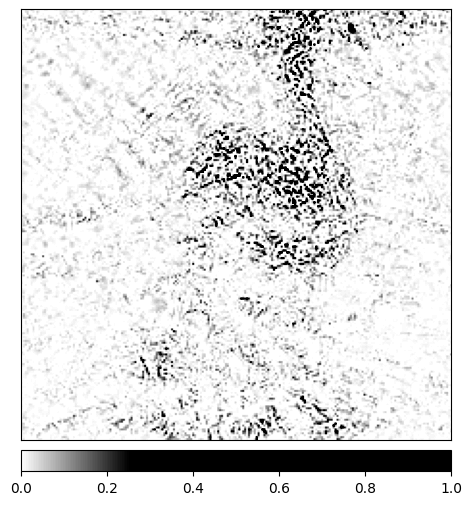

In [75]:
_ = viz.visualize_image_attr(
    attr=np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method="heat_map",  # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    sign="positive",    # [positive, absolute_value, negative, all]
    cmap=default_cmap,
    show_colorbar=True,
    outlier_perc=1
)

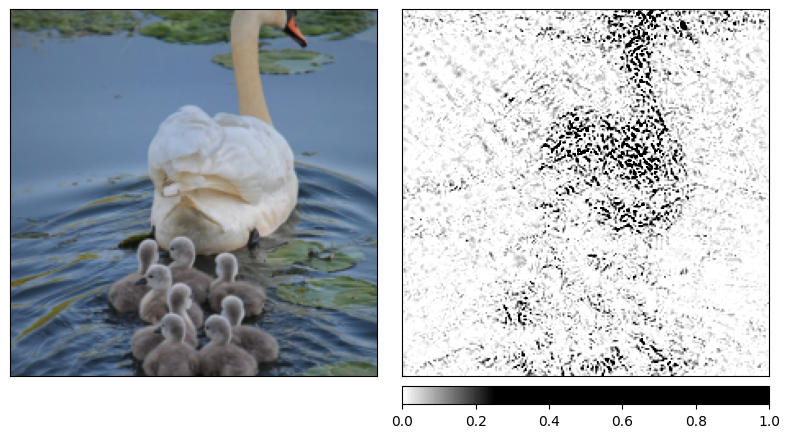

In [89]:
_ = viz.visualize_image_attr_multiple(
    attr=np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    methods=["original_image", "heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "positive"],              # [positive, absolute_value, negative, all]
    cmap=default_cmap,
    show_colorbar=True,
)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

---

让我们使用积分梯度计算归因，并在<em>噪声隧道</em>生成的多个图像上平滑它们。 后者向输入添加 std 等于 1、10 倍 (nt_samples=10) 的高斯噪声。 最终，噪声隧道使用 `smoothgrad_sq` 技术平滑 `nt_samples` 噪声样本的归因。`smoothgrad_sq` 表示 `nt_samples` 样本的平方属性的平均值。

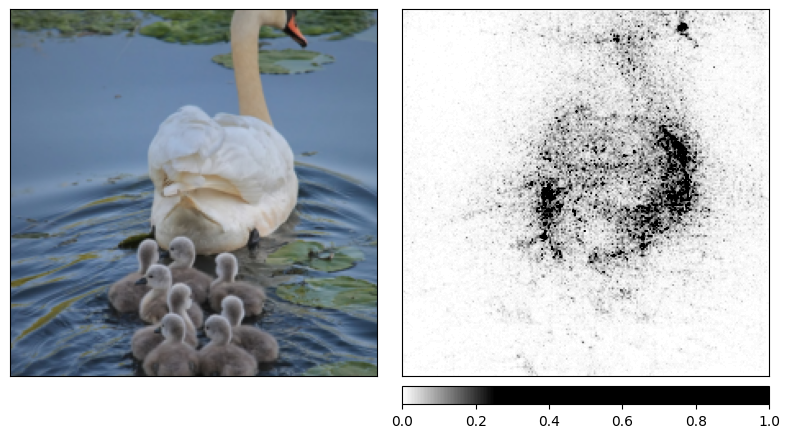

In [90]:
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions_ig_nt = noise_tunnel.attribute(inputs=input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(
    attr=np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    methods=["original_image", "heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "positive"],              # [positive, absolute_value, negative, all]
    cmap=default_cmap,
    show_colorbar=True,
)

Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

---

最后，让我们使用 `GradientShap`，这是一种线性解释模型，它使用参考样本（在本例中为两个图像）的分布来解释模型的预测。 它计算在输入和基线之间随机选择的输入的梯度期望。 基线也是从给定的基线分布中随机选择的。

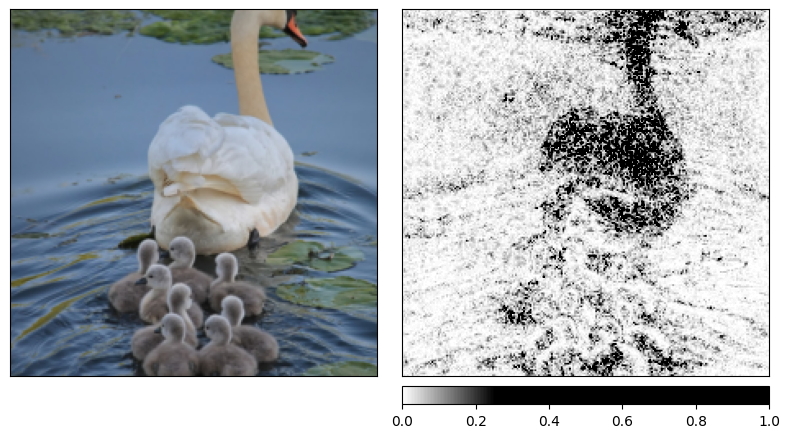

In [85]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(
    inputs=input,
    n_samples=50,
    stdevs=0.0001,
    baselines=rand_img_dist,
    target=pred_label_idx
)
_ = viz.visualize_image_attr_multiple(
    attr=np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    methods=["original_image", "heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "absolute_value"],        # [positive, absolute_value, negative, all]
    cmap=default_cmap,
    show_colorbar=True
)

## 3- Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

---

现在让我们尝试一种不同的归因方法。 我们可以通过遮挡图像的哪些区域并量化决策的变化来估计图像的哪些区域对于分类器的决策至关重要。

我们运行一个大小为 15x15 的滑动窗口（通过 `sliding_window_shapes` 定义），沿两个图像维度的步幅均为 8（通过 `strides` 定义）。 在每个位置，我们用基线值 0 遮挡图像，该基线值对应于灰色补丁（通过 `baselines` 定义）。

**注意：** 此计算可能需要一分钟以上才能完成，因为模型是在滑动窗口的每个位置进行评估的。

In [23]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    inputs=input,
    strides = (3, 8, 8),                # 步幅
    target=pred_label_idx,              # 目标id
    sliding_window_shapes=(3, 15, 15),  # windows size
    baselines=0
)
attributions_occ.shape

torch.Size([1, 3, 224, 224])

Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

---

让我们可视化归因，重点关注具有积极归因的区域（对于分类器的决策至关重要的区域）：

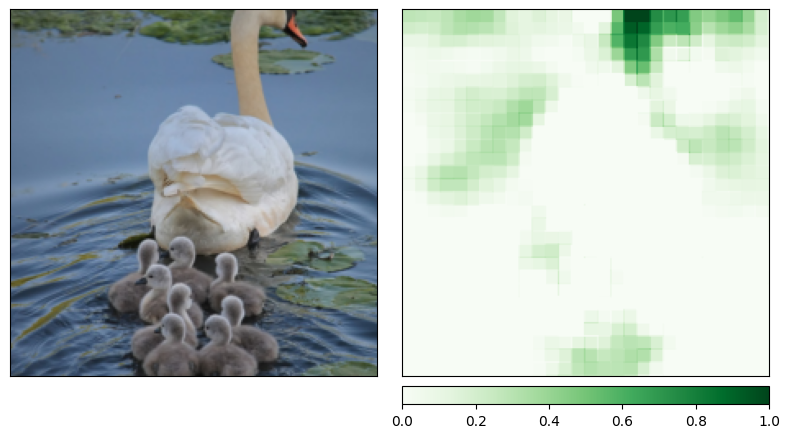

In [24]:
_ = viz.visualize_image_attr_multiple(
    attr=np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    methods=["original_image", "heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "positive"],              # [positive, absolute_value, negative, all]
    show_colorbar=True,
    outlier_perc=2
)

The upper part of the goose, especially the beak, seems to be the most critical for the model to predict this class.

We can verify this further by occluding the image using a larger sliding window:

---

鹅的上半部分，尤其是喙，似乎对于模型预测此类最为关键。

我们可以通过使用更大的滑动窗口遮挡图像来进一步验证这一点

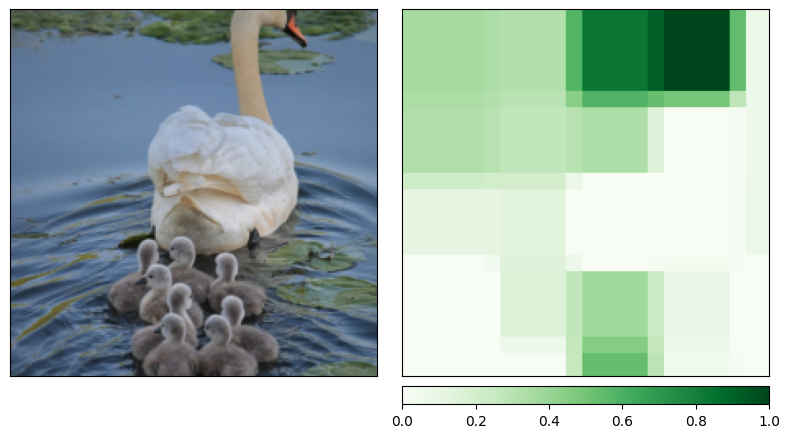

In [25]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    inputs=input,
    strides = (3, 50, 50),              # 步幅
    target=pred_label_idx,              # 目标id
    sliding_window_shapes=(3,60, 60),   # windows size
    baselines=0
)

_ = viz.visualize_image_attr_multiple(
    attr=np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    methods=["original_image", "heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "positive"],              # [positive, absolute_value, negative, all]
    show_colorbar=True,
    outlier_perc=2
)

 ## 4- LRP-based attribution

Now let's try a different approach called Layer-Wise Relevance Propagation (LRP). It uses a backward propagation mechanism applied sequentially to all layers of the model, to see which neurons contributed to the output. The output score of LRP represents the relevance, decomposed into values for each layer.
The decomposition is defined by rules that may vary for each layer.

Initially, we apply a direct implementation of LRP attribution. The default Epsilon-Rule is used for each layer.

Note: We use the VGG16 model instead here since the default rules for LRP are not fine-tuned for ResNet currently.

---

现在让我们尝试一种不同的方法，称为逐层相关性传播 (LRP)。 它使用向后传播机制，顺序应用于模型的所有层，以查看哪些神经元对输出做出了贡献。 LRP 的输出分数代表相关性，分解为每一层的值。
分解由每层可能不同的规则定义。

最初，我们应用 LRP 归因的直接实现。 每个层都使用默认的 Epsilon 规则。

注意：我们在这里使用 VGG16 模型，因为目前 LRP 的默认规则尚未针对 ResNet 进行微调。

In [93]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.eval()
lrp = LRP(model)

attributions_lrp = lrp.attribute(
    inputs=input,
    target=pred_label_idx
)
attributions_lrp.shape

d:\miniconda3\envs\pytorch\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([1, 3, 224, 224])

Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

---

让我们可视化归因，重点关注具有积极归因的区域（对于分类器的决策至关重要的区域）：

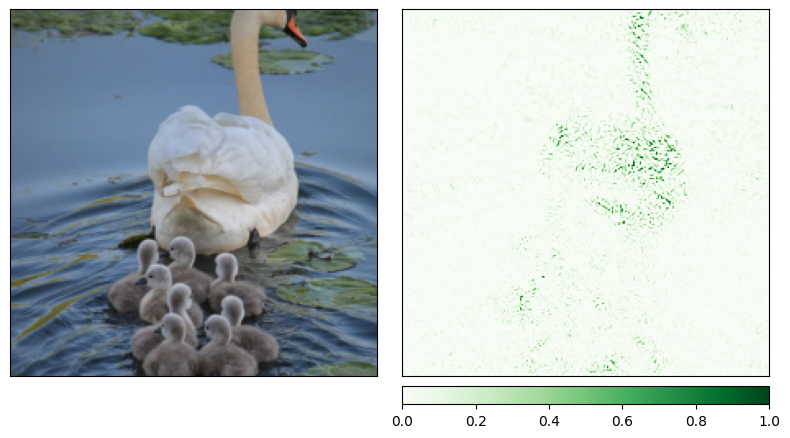

In [98]:
_ = viz.visualize_image_attr_multiple(
    attr=np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    methods=["original_image", "heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "positive"],              # [positive, absolute_value, negative, all]
    show_colorbar=True,
    outlier_perc=2
)

Now let's play around with changing the propagation rules for the various layers. This is a crucial step to get expressive heatmaps. Captum currently has the following propagation rules implemented: LRP-Epsilon, LRP-0, LRP-Gamma, LRP-Alpha-Beta, and the Identity-Rule.

In the next steps, we list all the layers of VGG16 and assign a rule to each one.

Note: Reference for recommmendations on how to set the rules can be found in *[Towards best practice in explaining neural network decisions with LRP](https://arxiv.org/abs/1910.09840)*.

---

现在让我们尝试更改各个层的传播规则。 这是获得富有表现力的热图的关键步骤。 Captum 目前实现了以下传播规则：LRP-Epsilon、LRP-0、LRP-Gamma、LRP-Alpha-Beta 和 Identity-Rule。

在接下来的步骤中，我们列出 VGG16 的所有层并为每个层分配一个规则。

注意：有关如何设置规则的建议参考可以在 *[使用 LRP 解释神经网络决策的最佳实践](https://arxiv.org/abs/1910.09840)* 中找到。

In [99]:
layers = list(model._modules["features"]) + list(model._modules["classifier"])
num_layers = len(layers)

for idx_layer in range(1, num_layers):
    if idx_layer <= 16:
        setattr(layers[idx_layer], "rule", GammaRule())
    elif 17 <= idx_layer <= 30:
        setattr(layers[idx_layer], "rule", EpsilonRule())
    elif idx_layer >= 31:
        setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0))

lrp = LRP(model)
attributions_lrp = lrp.attribute(
    inputs=input,
    target=pred_label_idx
)
attributions_lrp.shape

d:\miniconda3\envs\pytorch\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([1, 3, 224, 224])

Let us visualize the new attribution. As we can see in the generated output image, the heatmap shows clearly positive attributions forthe beak of the swan.

---

让我们想象一下新的归因。 正如我们在生成的输出图像中看到的，热图清楚地显示了天鹅喙的积极归因。

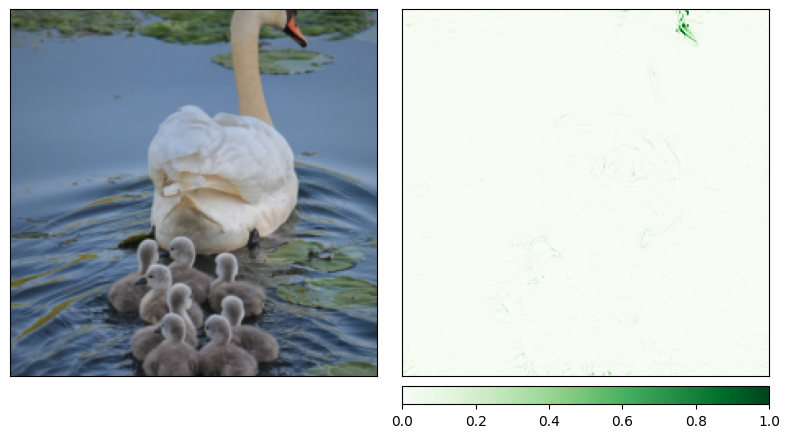

In [104]:
_ = viz.visualize_image_attr_multiple(
    attr=np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    original_image=np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    methods=["original_image", "heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "positive"],              # [positive, absolute_value, negative, all]
    show_colorbar=True,
    outlier_perc=2
)